In [6]:
# only for colab
!git clone https://github.com/qnozo/AI_in_Industry_project
%cd AI_in_Industry_project/notebooks

Cloning into 'AI_in_Industry_project'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 131 (delta 41), reused 58 (delta 14), pack-reused 0
Receiving objects: 100% (131/131), 14.88 MiB | 3.96 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/AI_in_Industry_project/notebooks/AI_in_Industry_project/notebooks


In [1]:
import os 
from pathlib import Path

PATH = str(Path(os.getcwd()).parent)

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np


import utils.utils as utils
import utils.models as models

import tensorflow as tf
from tensorflow.keras import callbacks

from itertools import product
from pathlib import Path

figsize=(14, 5)
verbose = 1
saveModel = False
stop = 1400 

# Improve usage of unsupervised data for the definition of RUL-based maintenance policies

Remain Useful Life refers to the time until a component becomes unserviceable and it requires a replacement. The prediction of RUL helps to delay maintenance operations until they are really needed. Therefore, it leads to optimize operating efficiency and avoid unplanned downtime. The problem is that in order to make a RUL prediction we need many run-to-failure experiments. These are usually expensive and time consuming. For this reason, it is usually not possible to produce the experiments in large quantities and we are limited to a small amount. However, we have a lot of data about the normal functioning of the components. So, in this project we try to exploit external knowledge about the machine in order to improve our capability to predict the RUL. In particular RUL has one property:
- The RUL has a decreasing monotone behaviour.

So we inject this knowledge using a Semantic based Regularizer and we optimize the regularizer by the mean of Lagrangian Dual Framework.

## Data loading and Preparation
For our experiment we use the C-MAPSS data set. C-MAPSS stands for 'Commercial Modular Aero-Propulsion System Simulation' and it includes run-to-failure sensor records of multiple aero-engines
collected under different operational conditions and fault modes.

- It is a tool for the simulation of realistic large commercial - turbofan engine data.
- The dataset consists of 4 training set files and 4 test set files.
- The training set files contain multiple run-to-failure experiments.
- The test set files contain truncated experiments.


In [3]:
path = os.path.join(PATH, 'data', 'CMAPSS')


data = utils.load_cmapss_data(path, 'train_*.txt')

# Identify input columns
dt_in = list(data.columns[3:-1])


In [4]:
data_by_src = utils.split_by_field(data, field='src')

dt = data_by_src['train_FD004']
dt[dt_in] = dt[dt_in].astype(np.float32)
print(dt.shape)
dt.head()

(61249, 28)


,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,42.004902,0.8400,100.0,445.000000,549.679993,1343.430054,1112.930054,...,2387.989990,8074.830078,9.3335,0.02,330.0,2212.0,100.00,10.620000,6.3670,320
1,train_FD004,461,2,20.002001,0.7002,100.0,491.190002,606.070007,1477.609985,1237.500000,...,2387.729980,8046.129883,9.1913,0.02,361.0,2324.0,100.00,24.370001,14.6552,319
2,train_FD004,461,3,42.003799,0.8409,100.0,445.000000,548.950012,1343.119995,1117.050049,...,2387.969971,8066.620117,9.4007,0.02,329.0,2212.0,100.00,10.480000,6.4213,318
3,train_FD004,461,4,42.000000,0.8400,100.0,445.000000,548.700012,1341.239990,1118.030029,...,2388.020020,8076.049805,9.3369,0.02,328.0,2212.0,100.00,10.540000,6.4176,317
4,train_FD004,461,5,25.006300,0.6207,60.0,462.540009,536.099976,1255.229980,1033.589966,...,2028.079956,7865.799805,10.8366,0.02,305.0,1915.0,84.93,14.030000,8.6754,316


Let's first check if there are any missing values.

In [5]:
dt[dt_in].isnull().values.any()

False

In [6]:
dt.describe()

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,584.325181,134.311417,23.997313,0.571251,94.031578,472.930939,579.423035,1417.894897,1201.905518,8.031372,...,2335.209717,8067.666504,9.285586,0.023266,347.758301,2227.973145,97.756859,20.864311,12.518955,133.311417
std,71.995350,89.783389,14.780671,0.310710,14.253440,26.436731,37.342667,106.167366,119.327286,3.623157,...,128.208679,85.670006,0.750363,0.004684,27.807484,145.463654,5.368834,9.936445,5.962700,89.783389
min,461.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.479980,1242.670044,1024.420044,3.910000,...,2027.569946,7845.779785,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300,0.000000
25%,520.000000,62.000000,10.004600,0.250700,100.000000,445.000000,549.330017,1350.550049,1119.489990,3.910000,...,2387.909912,8062.629883,8.648000,0.020000,330.000000,2212.000000,100.000000,10.940000,6.566100,61.000000
50%,586.000000,123.000000,25.001400,0.700000,100.000000,462.540009,555.739990,1367.680054,1136.920044,7.050000,...,2388.060059,8083.810059,9.255600,0.020000,334.000000,2223.000000,100.000000,14.930000,8.960100,122.000000
75%,645.000000,191.000000,41.998100,0.840000,100.000000,491.190002,607.070007,1497.420044,1302.619995,10.520000,...,2388.169922,8128.350098,9.365800,0.030000,368.000000,2324.000000,100.000000,28.559999,17.135500,190.000000
max,709.000000,543.000000,42.007999,0.842000,100.000000,518.669983,644.419983,1613.000000,1440.770020,14.620000,...,2390.489990,8261.650391,11.066300,0.030000,399.000000,2388.000000,100.000000,39.889999,23.885201,542.000000


### Data Preprocessing

To simulate the scarcity of run-to-failure experiments at various level we split the dataset using multiple ratios.

In [7]:
trs_ratios = np.arange(0.03, 0.8, step=0.20)
tru_ratios = np.arange(0.75, 0.0, step=-0.20)
print(*('- {0} ratio: ({1:.0%} supervised, {2:.0%} unsupervised)'.format(i, trs_ratio, tru_ratio) for i, (trs_ratio, tru_ratio) in enumerate(zip(trs_ratios, tru_ratios), 1)), sep="\n")

- 1 ratio: (3% supervised, 75% unsupervised)
- 2 ratio: (23% supervised, 55% unsupervised)
- 3 ratio: (43% supervised, 35% unsupervised)
- 4 ratio: (63% supervised, 15% unsupervised)


### Training
For each split we train four different model:
- baseline model with two hidden layer of 32 neurons.
- model with a single fixed regularizer equals to 1
- model with a single regularizer optimized using the Lagrangian Dual Framework
- model with multiple regularizer (one for each constraint) optimized using the Lagrangian Dual Framework

Each model will be trained on 25 epochs with a batch of size 32

In [8]:
hidden = [32, 32]
batch_size = 32
epochs = 25

In [9]:


def get_data_base(trs_s, trsu_s, trmaxrul):
  return (trs_s[dt_in], trs_s["rul"])
def get_data_constrained(trs_s, trsu_s, trmaxrul):
  return models.CstBatchGenerator(trsu_s, dt_in, batch_size)

def build_base_model(model_class, input_shape, trmaxrul, data, *params):
  model = model_class(input_shape, hidden=hidden)
  model.compile("adam", "mse")
  history = model.fit(*data, epochs=epochs, batch_size=batch_size, verbose=0)
  return model, history

def build_constrained_model(model_class, input_shape, trmaxrul, data, *params):
  model = model_class(input_shape, trmaxrul, *params, hidden=hidden)
  model.compile("adam")
  
  history = model.fit(data, epochs=epochs, verbose=0)
  return model, history



In [10]:

configs = {
    "base":{
        "model":models.MLPRegressor,
        "build_model": build_base_model,
        "get_data": get_data_base,
        "params": None,
    },
    "constrained_fixed_multiplier":{
        "model":models.LagDualRULRegressor,
        "build_model": build_constrained_model,
        "get_data": get_data_constrained,
        "params": 1.
    },
    "constrained_lag":{
        "model":models.LagDualRULRegressor,
        "build_model": build_constrained_model,
        "get_data": get_data_constrained,
        "params": None
    },
    "multi_constrained_lag":{
        "model":models.LagDualRULRegressorMulti,
        "build_model": build_constrained_model,
        "get_data": get_data_constrained,
        "params": batch_size-1
        
    }
}

In [ ]:
mdls = []

for i, (trs_ratio, tru_ratio) in enumerate(zip(trs_ratios, tru_ratios)):
  tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio)
  ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)
  tru_s_by_m = utils.split_by_field(tru_s, 'machine')
  tru_st = utils.cut_off(tru_s)
  trsu_s = pd.concat((trs_s, tru_st))
  trsu_s.loc[tru_st.index, 'rul'] = -1
  
  for key in configs:
    print(key)
  
   
    config = configs[key]
    get_data = config["get_data"]
    data = get_data(trs_s, trsu_s, trmaxrul)
    build_model = config["build_model"]
    model, history = build_model(config["model"], len(dt_in), trmaxrul, data, config["params"])
  
    
    if saveModel:
      path = os.path.join(PATH, "models", key, str(i))
      model.save(path)
    mdls.append(model)
  

base
INFO:tensorflow:Assets written to: /content/drive/My Drive/Artificial Intelligence in Industry/project/models/base/0/assets
constrained_fixed_multiplier
INFO:tensorflow:Assets written to: /content/drive/My Drive/Artificial Intelligence in Industry/project/models/constrained_fixed_multiplier/0/assets
constrained_lag
INFO:tensorflow:Assets written to: /content/drive/My Drive/Artificial Intelligence in Industry/project/models/constrained_lag/0/assets
multi_constrained_lag
INFO:tensorflow:Assets written to: /content/drive/My Drive/Artificial Intelligence in Industry/project/models/multi_constrained_lag/0/assets
base
INFO:tensorflow:Assets written to: /content/drive/My Drive/Artificial Intelligence in Industry/project/models/base/1/assets
constrained_fixed_multiplier
INFO:tensorflow:Assets written to: /content/drive/My Drive/Artificial Intelligence in Industry/project/models/constrained_fixed_multiplier/1/assets
constrained_lag
INFO:tensorflow:Assets written to: /content/drive/My Drive

## Evaluation

For each ratio supervised/unsupervised in which we split the data set we make predictions on the current split using the models. Then we plot the result we obtain on the test set and the cost model.

In [11]:
mdls = [] 
for i in range(len(trs_ratios)):
  for key in configs: 
      path = os.path.join(PATH, "models", key, str(i))
      model = tf.keras.models.load_model(path)
      mdls.append(model)



### 3% supervised 75% unsupervised

In [19]:
index = 0
trs_ratio = trs_ratios[index]
tru_ratio = tru_ratios[index]
tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio)
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)

# tr, ts, trs, tru = splitted[index]
# ts_s, tr_s, trs_s, tru_s, trsu_s, trmaxrul = splitted_s[index]


In [18]:
predictions = []
for i in range(int(len(mdls)/len(configs)* index), int(len(mdls)/len(configs)* (index+1))):
  trs_pred = mdls[i].predict(trs_s[dt_in]).ravel() * trmaxrul
  tru_pred = mdls[i].predict(tru_s[dt_in]).ravel() * trmaxrul
  ts_pred = mdls[i].predict(ts_s[dt_in]).ravel() * trmaxrul
  predictions.append((trs_pred, tru_pred, ts_pred))

base


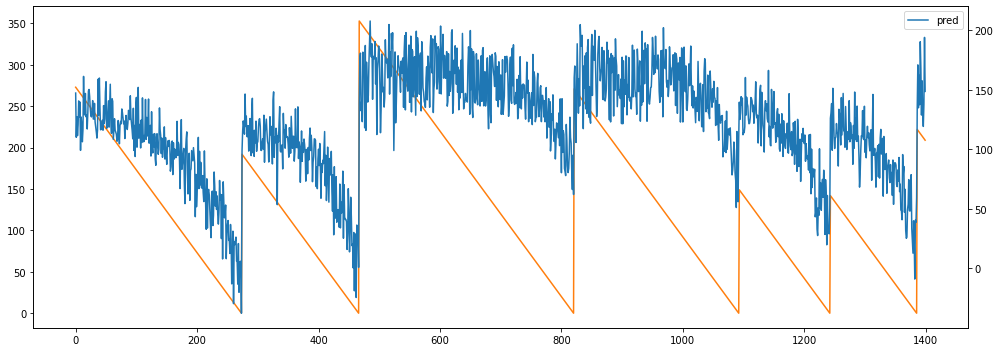

constrained_fixed_multiplier


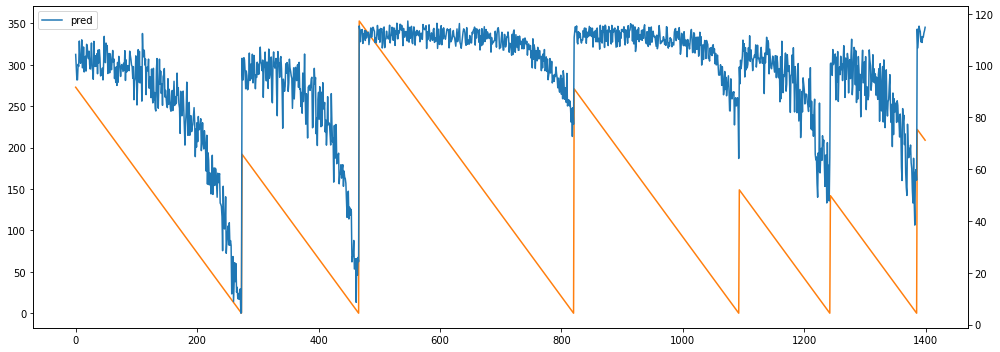

constrained_lag


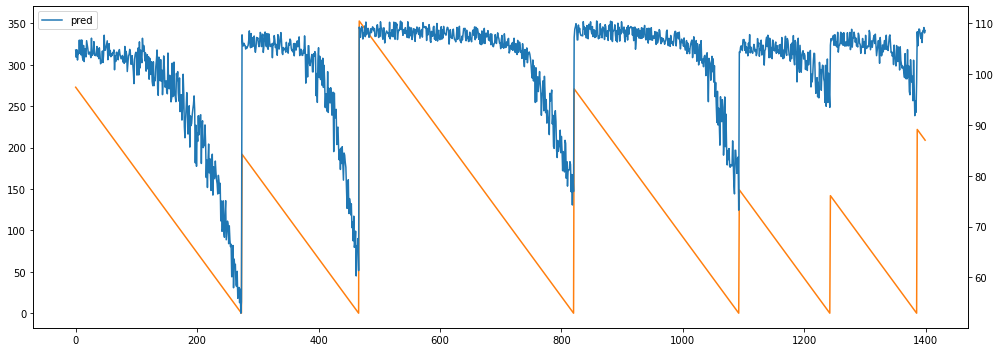

multi_constrained_lag


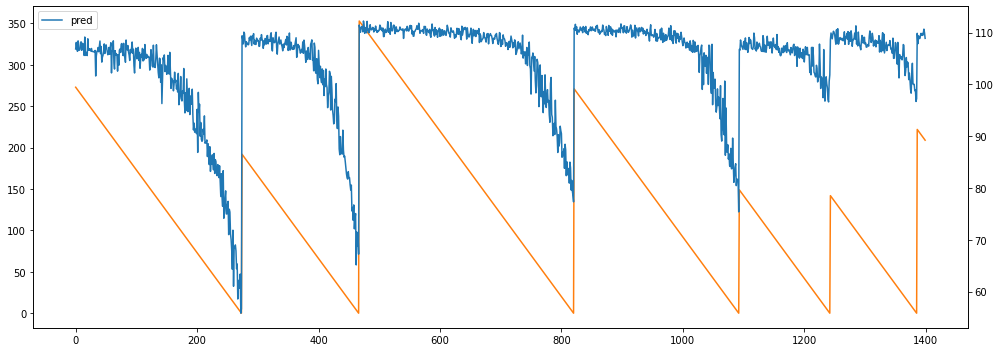

In [19]:
for i, prediction in enumerate(predictions):
  _, _, ts_pred = prediction
  print(list(configs.keys())[i])
  utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)
  
  


base


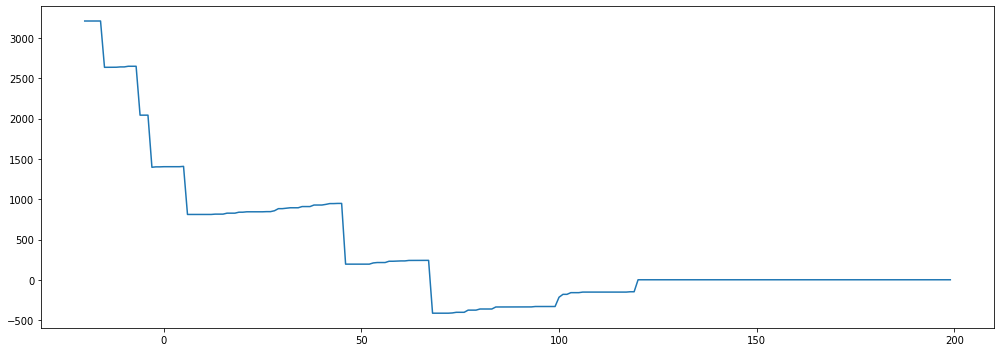

Optimal threshold for the training set: 68
Cost: -415 (supervised), 1100 (unsupervised), 2157 (test)
Avg. fails: 0.00 (supervised), 0.12 (unsupervised), 0.20 (test)
Avg. slack: 39.14 (supervised), 38.52 (unsupervised), 37.96 (test)

constrained_fixed_multiplier


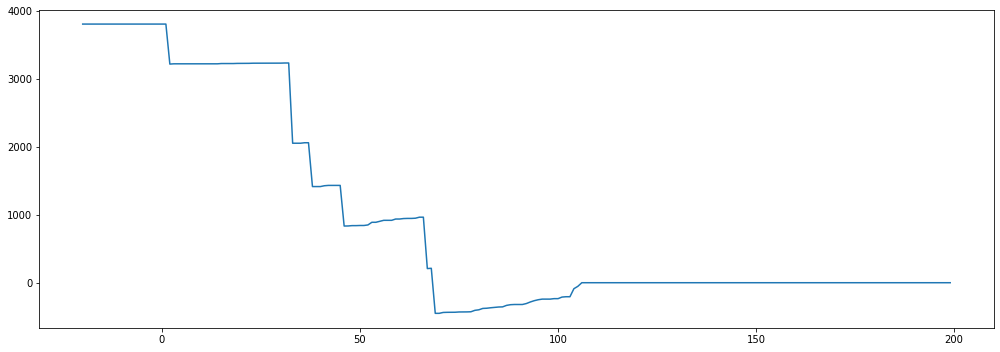

Optimal threshold for the training set: 69
Cost: -450 (supervised), 30131 (unsupervised), 11388 (test)
Avg. fails: 0.00 (supervised), 0.35 (unsupervised), 0.43 (test)
Avg. slack: 32.71 (supervised), 28.44 (unsupervised), 26.00 (test)

constrained_lag


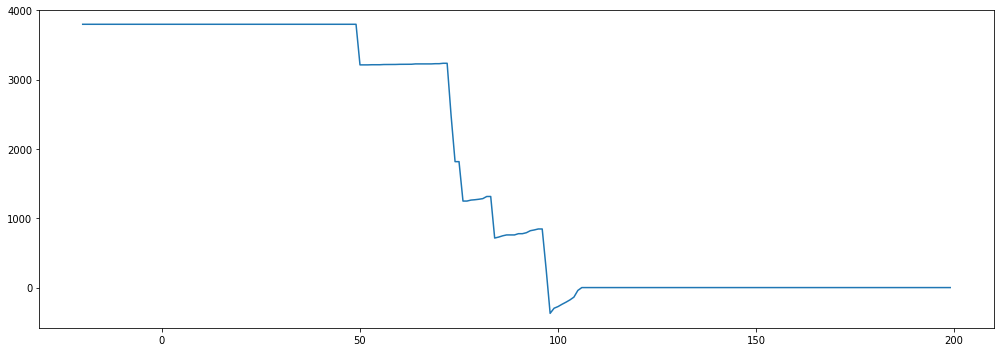

Optimal threshold for the training set: 98
Cost: -372 (supervised), -2644 (unsupervised), -1216 (test)
Avg. fails: 0.00 (supervised), 0.06 (unsupervised), 0.05 (test)
Avg. slack: 54.43 (supervised), 73.30 (unsupervised), 84.46 (test)

multi_constrained_lag


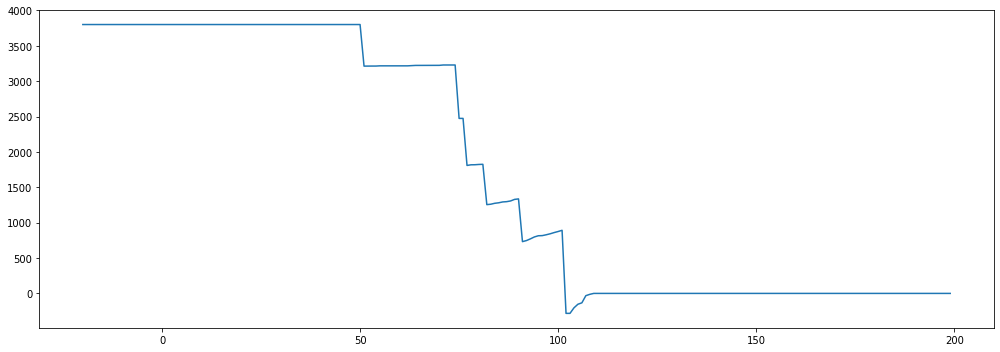

Optimal threshold for the training set: 102
Cost: -282 (supervised), -1658 (unsupervised), 999 (test)
Avg. fails: 0.00 (supervised), 0.06 (unsupervised), 0.11 (test)
Avg. slack: 73.29 (supervised), 82.19 (unsupervised), 96.27 (test)



In [20]:

for i, prediction in enumerate(predictions):

  print(list(configs.keys())[i])
  trs_pred, tru_pred, ts_pred = prediction
  # tr, ts, trs, tru
  failtimes = dt.groupby('machine')['cycle'].max() 
  safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

  trs_mcn = trs_s.machine.unique()
  tru_mcn = tru_s.machine.unique()
  ts_mcn = ts_s.machine.unique()

  cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
  th_range = np.arange(-20, 200)
  trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
  print(f'Optimal threshold for the training set: {trs_thr}')

  trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
  tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)

  ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
  print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

  trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
  print(f'Avg. fails: {trs_f/trs_nm:.2f} (supervised), {tru_f/tru_nm:.2f} (unsupervised), {ts_f/ts_nm:.2f} (test)')
  print(f'Avg. slack: {trs_sl/trs_nm:.2f} (supervised), {tru_sl/tru_nm:.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')
  print()

### 23% supervised 55% unsupervised

In [21]:
index = 1
trs_ratio = trs_ratios[index]
tru_ratio = tru_ratios[index]

tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio)
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)


In [22]:
predictions = []
for i in range(int(len(mdls)/len(configs)* index), int(len(mdls)/len(configs)* (index+1))):
  trs_pred = mdls[i].predict(trs_s[dt_in]).ravel() * trmaxrul
  tru_pred = mdls[i].predict(tru_s[dt_in]).ravel() * trmaxrul
  ts_pred = mdls[i].predict(ts_s[dt_in]).ravel() * trmaxrul
  predictions.append((trs_pred, tru_pred, ts_pred))

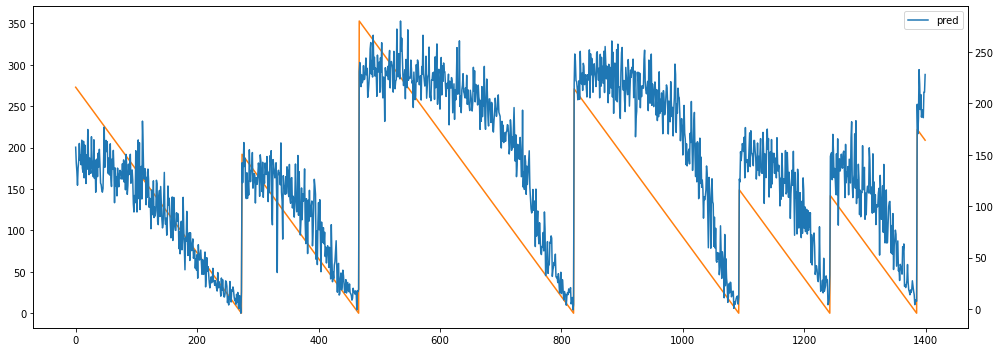

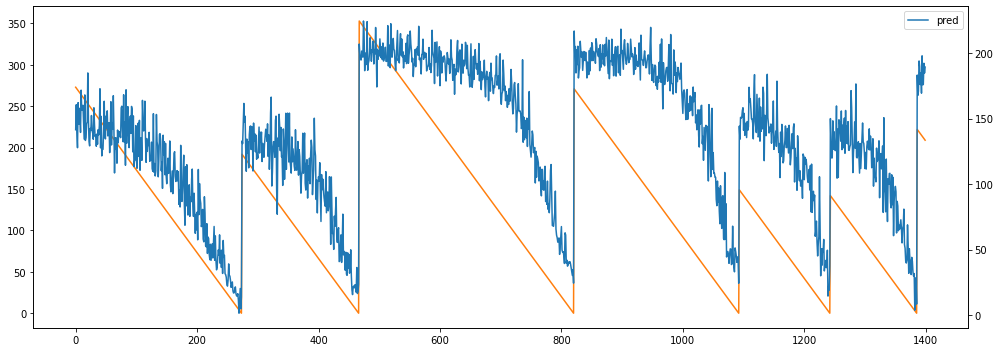

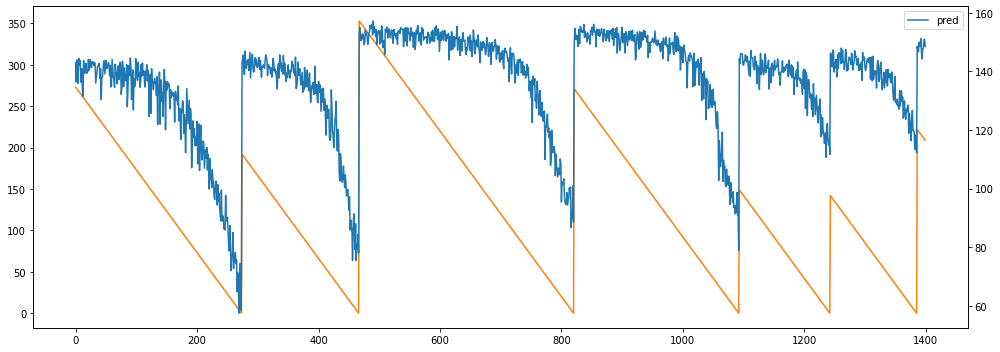

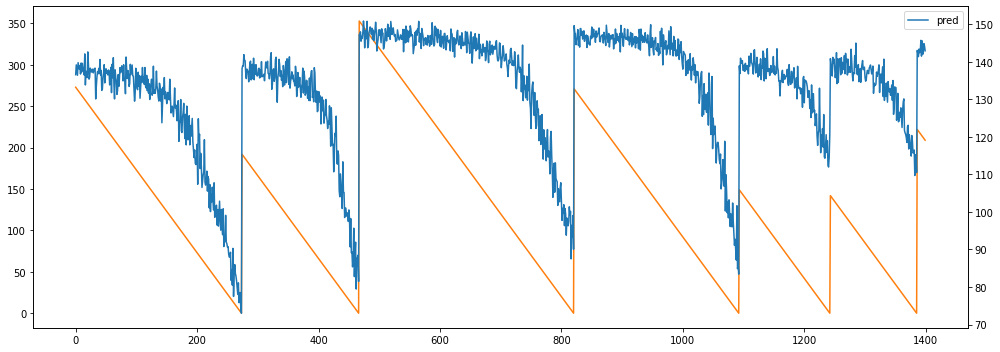

In [23]:
for i, prediction in enumerate(predictions):
  print(list(configs.keys())[i])
  _, _, ts_pred = prediction
  utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)


base


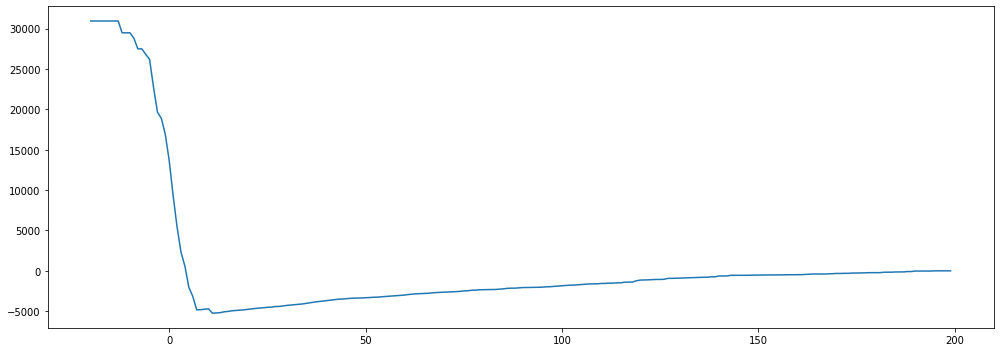

Optimal threshold for the training set: 11
Cost: -5248 (supervised), -12645 (unsupervised), -5944 (test)
Avg. fails: 0.00 (supervised), 0.01 (unsupervised), 0.00 (test)
Avg. slack: 14.47 (supervised), 17.04 (unsupervised), 20.04 (test)

constrained_fixed_multiplier


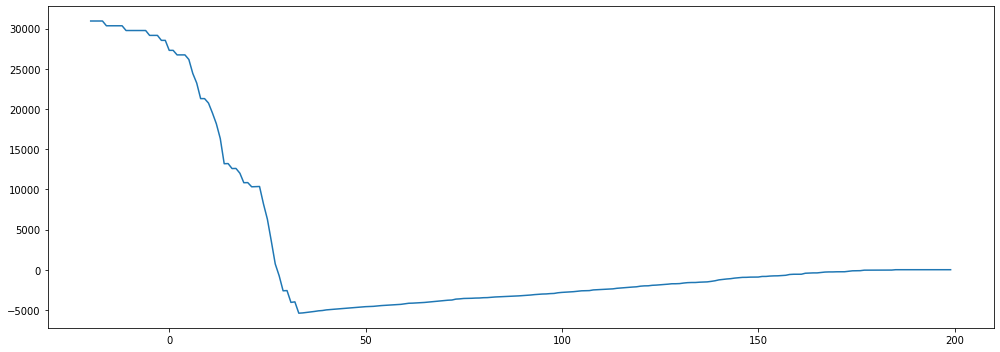

Optimal threshold for the training set: 33
Cost: -5411 (supervised), -12899 (unsupervised), -6032 (test)
Avg. fails: 0.00 (supervised), 0.01 (unsupervised), 0.00 (test)
Avg. slack: 11.63 (supervised), 15.13 (unsupervised), 18.54 (test)

constrained_lag


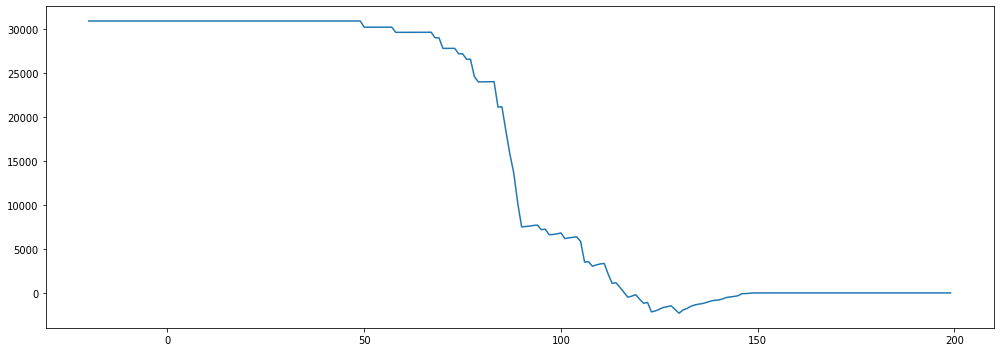

Optimal threshold for the training set: 130
Cost: -2308 (supervised), -5228 (unsupervised), -2180 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.00 (test)
Avg. slack: 84.30 (supervised), 105.56 (unsupervised), 112.89 (test)

multi_constrained_lag


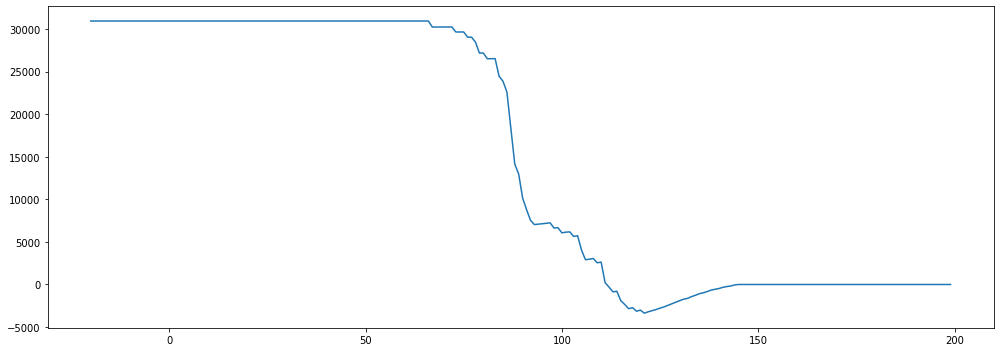

Optimal threshold for the training set: 121
Cost: -3372 (supervised), -9059 (unsupervised), -3757 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.00 (test)
Avg. slack: 48.39 (supervised), 53.23 (unsupervised), 61.07 (test)



In [24]:

for i, prediction in enumerate(predictions):

  print(list(configs.keys())[i])
  trs_pred, tru_pred, ts_pred = prediction
  # tr, ts, trs, tru
  failtimes = dt.groupby('machine')['cycle'].max() 
  safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

  trs_mcn = trs_s.machine.unique()
  tru_mcn = tru_s.machine.unique()
  ts_mcn = ts_s.machine.unique()

  cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
  th_range = np.arange(-20, 200)
  trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
  print(f'Optimal threshold for the training set: {trs_thr}')

  trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
  tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)

  ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
  print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

  trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
  print(f'Avg. fails: {trs_f/trs_nm:.2f} (supervised), {tru_f/tru_nm:.2f} (unsupervised), {ts_f/ts_nm:.2f} (test)')
  print(f'Avg. slack: {trs_sl/trs_nm:.2f} (supervised), {tru_sl/tru_nm:.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')
  print()

### 43% supervised 35% unsupervised

In [25]:
index = 2
trs_ratio = trs_ratios[index]
tru_ratio = tru_ratios[index]

tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio)
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)


In [26]:
predictions = []
for i in range(int(len(mdls)/len(configs)* index), int(len(mdls)/len(configs)* (index+1))):
  trs_pred = mdls[i].predict(trs_s[dt_in]).ravel() * trmaxrul
  tru_pred = mdls[i].predict(tru_s[dt_in]).ravel() * trmaxrul
  ts_pred = mdls[i].predict(ts_s[dt_in]).ravel() * trmaxrul
  predictions.append((trs_pred, tru_pred, ts_pred))

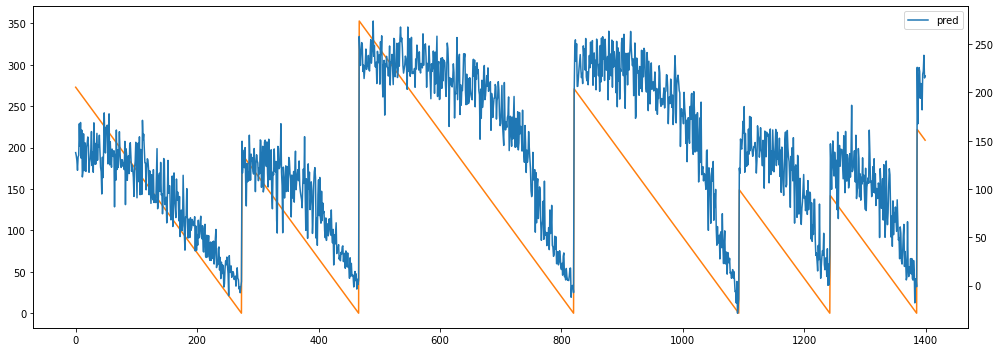

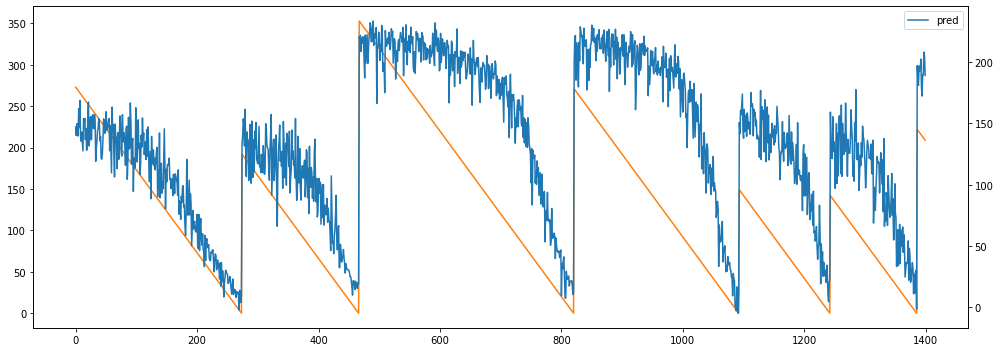

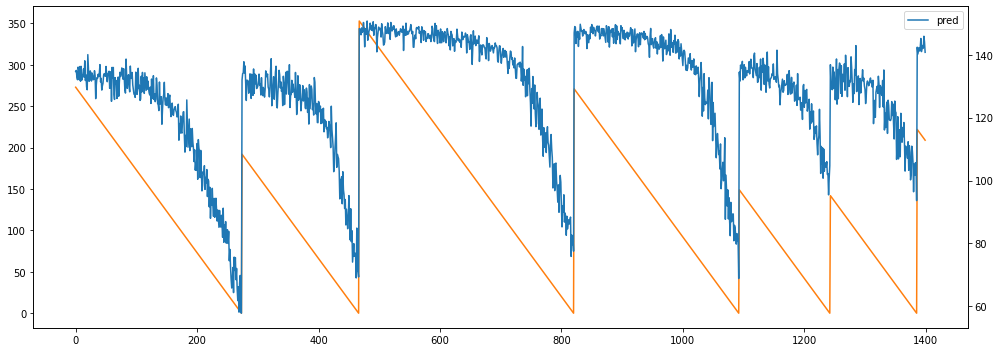

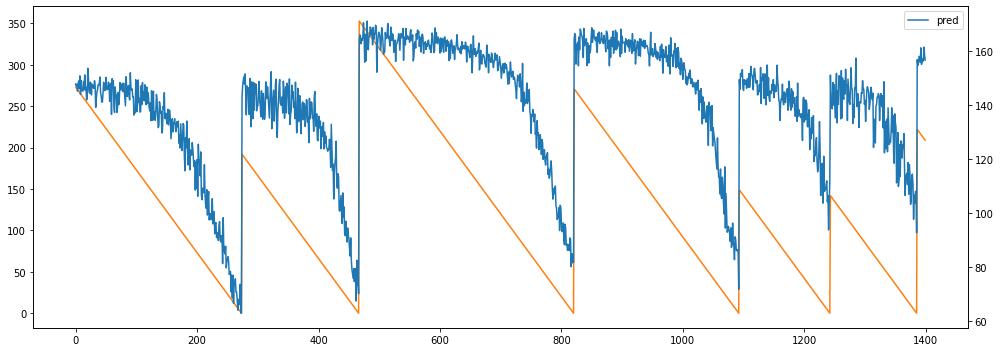

In [27]:
for i, prediction in enumerate(predictions):
  print(list(configs.keys())[i])
  _, _, ts_pred = prediction
  utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)


base


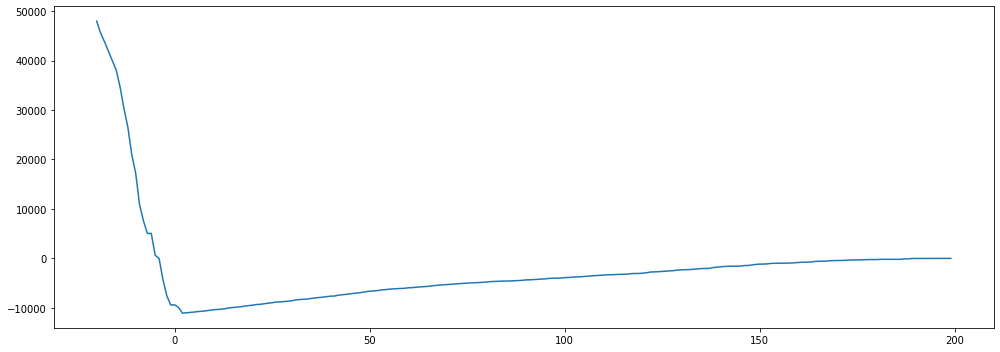

Optimal threshold for the training set: 2
Cost: -11081 (supervised), -8079 (unsupervised), -5444 (test)
Avg. fails: 0.00 (supervised), 0.02 (unsupervised), 0.02 (test)
Avg. slack: 10.10 (supervised), 12.00 (unsupervised), 15.07 (test)

constrained_fixed_multiplier


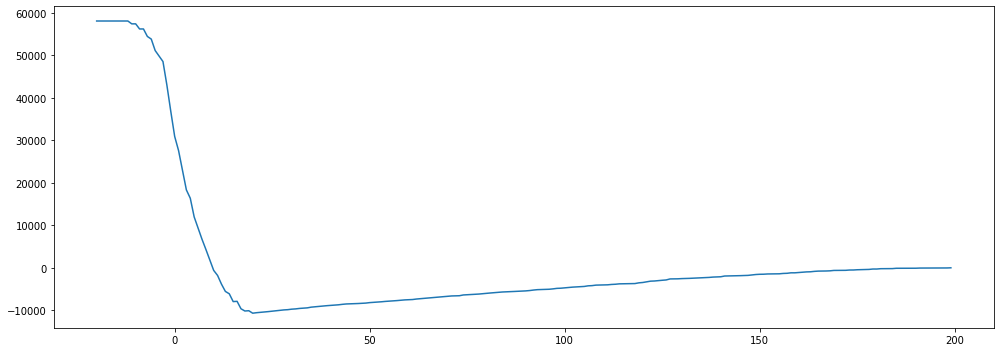

Optimal threshold for the training set: 20
Cost: -10684 (supervised), -8949 (unsupervised), -5735 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.00 (test)
Avg. slack: 13.79 (supervised), 16.34 (unsupervised), 20.42 (test)

constrained_lag


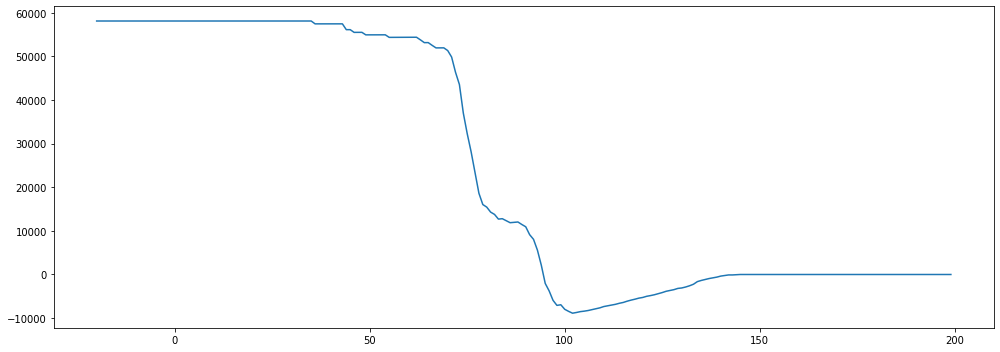

Optimal threshold for the training set: 102
Cost: -8870 (supervised), -7653 (unsupervised), -4674 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.00 (test)
Avg. slack: 30.85 (supervised), 31.31 (unsupervised), 39.80 (test)

multi_constrained_lag


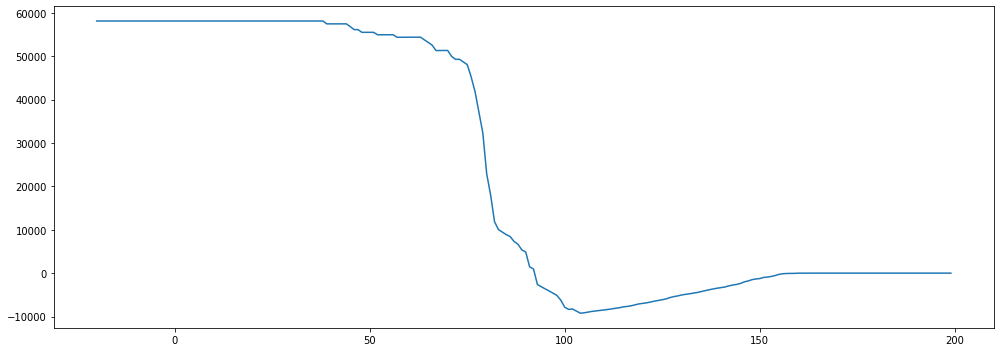

Optimal threshold for the training set: 104
Cost: -9231 (supervised), -7955 (unsupervised), -4960 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.00 (test)
Avg. slack: 27.37 (supervised), 27.75 (unsupervised), 34.55 (test)



In [28]:

for i, prediction in enumerate(predictions):

  print(list(configs.keys())[i])
  trs_pred, tru_pred, ts_pred = prediction
  # tr, ts, trs, tru
  failtimes = dt.groupby('machine')['cycle'].max() 
  safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

  trs_mcn = trs_s.machine.unique()
  tru_mcn = tru_s.machine.unique()
  ts_mcn = ts_s.machine.unique()

  cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
  th_range = np.arange(-20, 200)
  trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
  print(f'Optimal threshold for the training set: {trs_thr}')

  trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
  tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)

  ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
  print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

  trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
  print(f'Avg. fails: {trs_f/trs_nm:.2f} (supervised), {tru_f/tru_nm:.2f} (unsupervised), {ts_f/ts_nm:.2f} (test)')
  print(f'Avg. slack: {trs_sl/trs_nm:.2f} (supervised), {tru_sl/tru_nm:.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')
  print()

### 63% supervised 15% unsupervised

In [29]:
index = 3
trs_ratio = trs_ratios[index]
tru_ratio = tru_ratios[index]

tr, ts, trs, tru = utils.supervised_unsupervised_split(dt, trs_ratio, tru_ratio)
ts_s, tr_s, trs_s, tru_s, trmaxrul = utils.standardize_and_normalize(ts, tr, trs, tru, dt_in)


In [30]:
predictions = []
for i in range(int(len(mdls)/len(configs)* index), int(len(mdls)/len(configs)* (index+1))):
  trs_pred = mdls[i].predict(trs_s[dt_in]).ravel() * trmaxrul
  tru_pred = mdls[i].predict(tru_s[dt_in]).ravel() * trmaxrul
  ts_pred = mdls[i].predict(ts_s[dt_in]).ravel() * trmaxrul
  predictions.append((trs_pred, tru_pred, ts_pred))

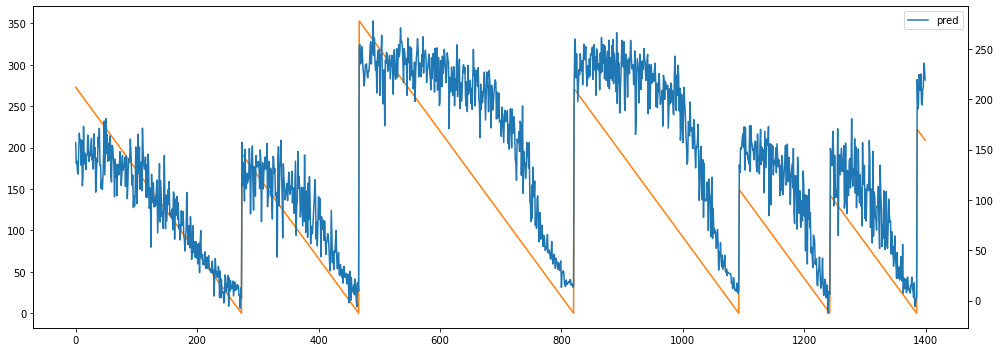

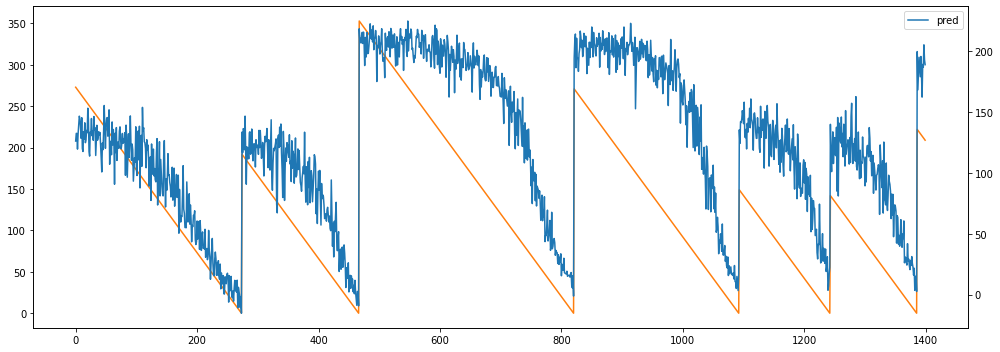

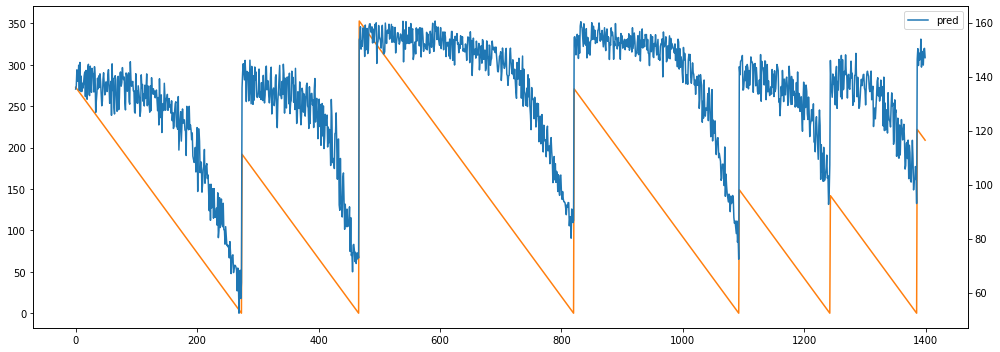

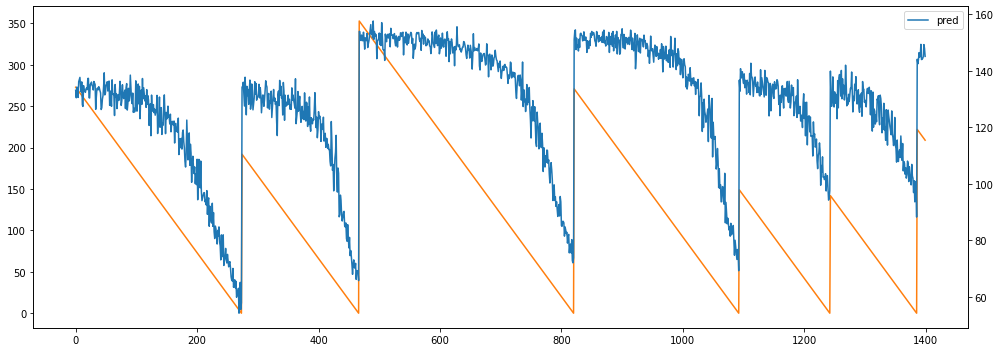

In [31]:
for i, prediction in enumerate(predictions):
  _, _, ts_pred = prediction
  utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)


base


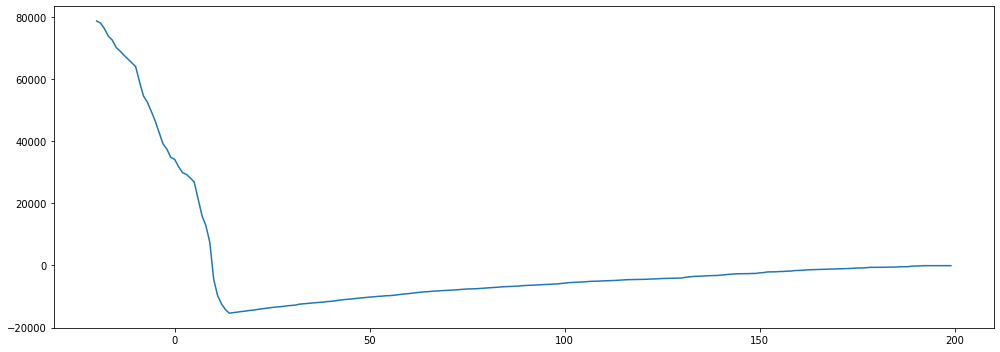

Optimal threshold for the training set: 14
Cost: -15375 (supervised), -3196 (unsupervised), -5818 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.00 (test)
Avg. slack: 18.72 (supervised), 23.54 (unsupervised), 22.61 (test)

constrained_fixed_multiplier


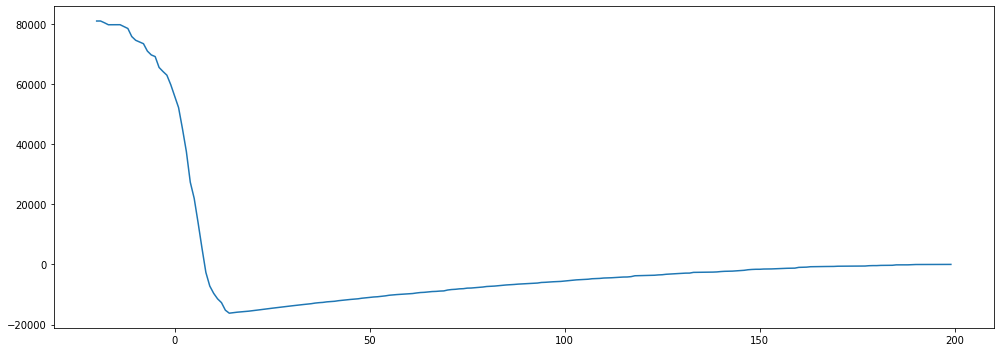

Optimal threshold for the training set: 14
Cost: -16218 (supervised), -3412 (unsupervised), -5385 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.02 (test)
Avg. slack: 13.01 (supervised), 17.70 (unsupervised), 19.57 (test)

constrained_lag


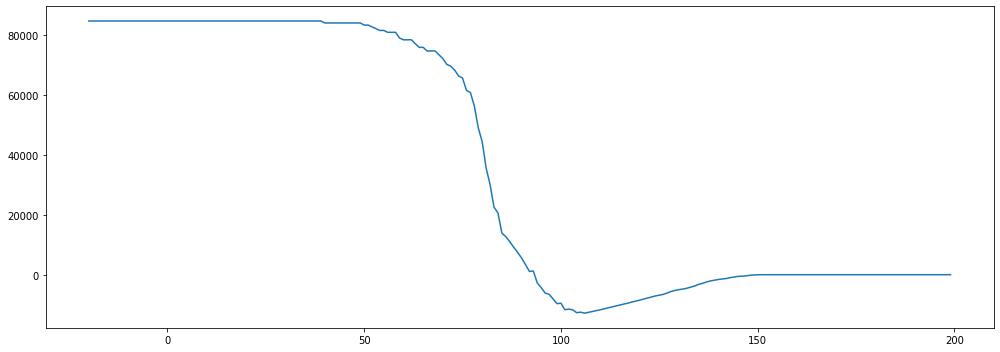

Optimal threshold for the training set: 106
Cost: -12852 (supervised), -2630 (unsupervised), -4639 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.00 (test)
Avg. slack: 34.87 (supervised), 38.84 (unsupervised), 43.73 (test)

multi_constrained_lag


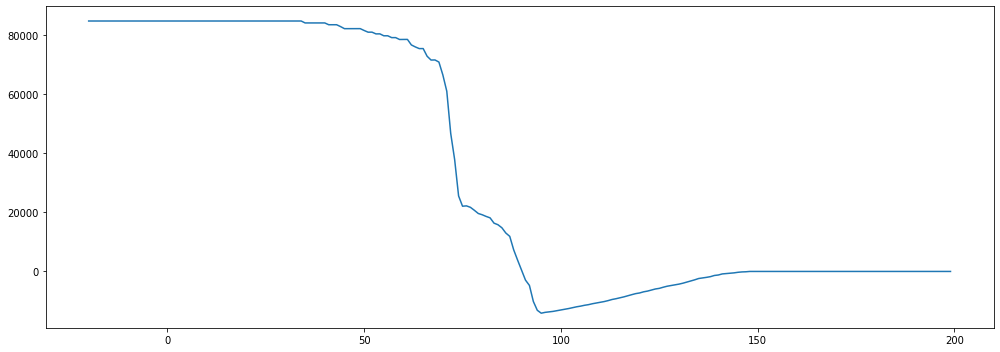

Optimal threshold for the training set: 95
Cost: -14122 (supervised), -3053 (unsupervised), -5093 (test)
Avg. fails: 0.00 (supervised), 0.00 (unsupervised), 0.00 (test)
Avg. slack: 26.53 (supervised), 27.41 (unsupervised), 35.34 (test)



In [32]:

for i, prediction in enumerate(predictions):

  print(list(configs.keys())[i])
  trs_pred, tru_pred, ts_pred = prediction
  # tr, ts, trs, tru
  failtimes = dt.groupby('machine')['cycle'].max() 
  safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

  trs_mcn = trs_s.machine.unique()
  tru_mcn = tru_s.machine.unique()
  ts_mcn = ts_s.machine.unique()

  cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
  th_range = np.arange(-20, 200)
  trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
  print(f'Optimal threshold for the training set: {trs_thr}')

  trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
  tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)

  ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
  print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

  trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
  print(f'Avg. fails: {trs_f/trs_nm:.2f} (supervised), {tru_f/tru_nm:.2f} (unsupervised), {ts_f/ts_nm:.2f} (test)')
  print(f'Avg. slack: {trs_sl/trs_nm:.2f} (supervised), {tru_sl/tru_nm:.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')
  print()